In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# Declare base using automap_base
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [7]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base, these are the tables
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# look at first row of measurement table, to identify column names and what form the data takes
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1efe4995540>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1}

In [11]:
# do the same thing for station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1efe4996680>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [25]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

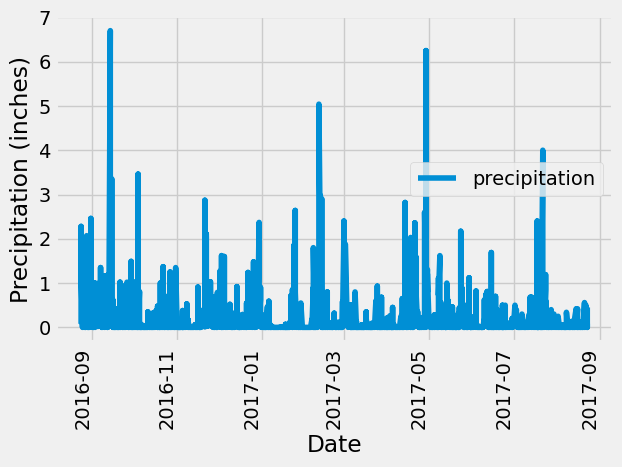

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_earlier = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_earlier).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# convert date from string to datetime
precip_df['date'] = pd.to_datetime(precip_df['date'])

# Sort the dataframe by date, drop nan values 
precip_sorted = precip_df.sort_values(by='date')
precip_sorted.dropna(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
precip_sorted.plot(x='date', y='precipitation', xlabel='Date', ylabel='Precipitation (inches)')
# set the x axis labels to show the date vertically for readability
plt.xticks(rotation='vertical')
plt.show()

In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [73]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement).group_by(Measurement.station).count()

9

In [76]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [77]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

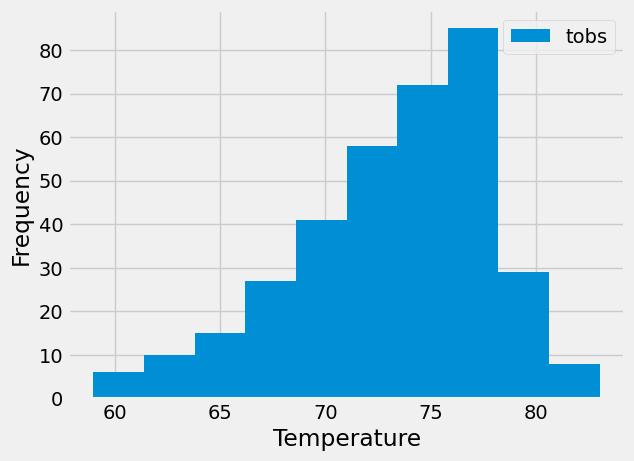

In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_station = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > dt.date(2016, 8, 23)).all()
# make the results into dataframe for plotting
station_db = pd.DataFrame(results_station)

# plot results as histogram
station_db.plot(kind='hist', xlabel='Temperature', ylabel='Frequency')
plt.show()

# Close Session

In [81]:
# Close Session
session.close()